# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.clean()
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ===================================== >>
Models: LGB
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9854
Test evaluation --> roc_auc: 0.8788
Time elapsed: 0.303s
-------------------------------------------------
Total time: 0.303s


Final results ========================= >>
Duration: 0.304s
------------------------------------------
LightGBM --> roc_auc: 0.8788


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created!


In [6]:
# Create 50 new features using DFS
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added to the dataset.


divide by zero encountered in log


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

LOG(Sunshine)        156
LOG(WindSpeed3pm)     34
dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 156 missing values using the KNN imputer in feature LOG(Sunshine).
 --> Imputing 34 missing values using the KNN imputer in feature LOG(WindSpeed3pm).


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number
atom.feature_selection(
    strategy="RFECV",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.2234864447253828 repeated in 100% of the rows.
 --> Feature Cloud3pm + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Cloud3pm + RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm - Location was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_No was removed due to collinearity with another feature.
 --> Feature Evaporation + WindGustDir was removed due to collinearity with another feature.
 --> Feature Evaporation - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Humidity9am - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Location + MinTemp was removed due to collinearity with another feature.
 --> Feature Location + RainToday_No was removed due to collinearity with another feature.
 --> Feature Loca

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + Humidity3pm,Humidity3pm,0.99558
1,Cloud3pm + RainToday_No,Cloud3pm,0.98138
2,Cloud3pm - Location,"Cloud3pm, Cloud3pm + RainToday_No","1.0, 0.98138"
3,Cloud3pm - RainToday_No,"Cloud3pm, Cloud3pm - Location","0.98407, 0.98407"
4,Evaporation + WindGustDir,Evaporation,0.99989
5,Evaporation - WindDir3pm,"Evaporation, Evaporation + WindGustDir","0.99991, 0.9997"
6,Humidity9am - WindDir3pm,Humidity9am,1.0
7,Location + MinTemp,MinTemp,1.0
8,Location + RainToday_No,"RainToday_Yes, RainToday_No","-0.9836, 1.0"
9,Location + WindDir3pm,WindDir3pm,1.0


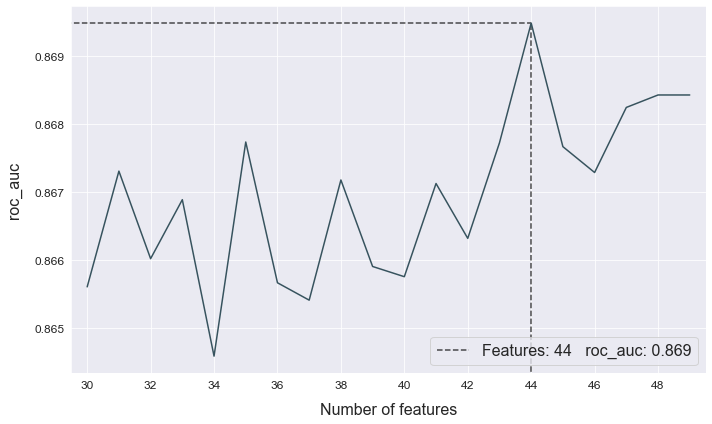

In [11]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ===================================== >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9917
Test evaluation --> roc_auc: 0.8691
Time elapsed: 0.493s
-------------------------------------------------
Total time: 0.493s


Final results ========================= >>
Duration: 0.493s
------------------------------------------
LightGBM --> roc_auc: 0.8691


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created!


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(
    strategy='GFG',
    n_features=20,
    generations=10,
    population=2000,
)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.17         0.126131        3          0.50226              N/A     10.12s
   1     3.07         0.340705        5         0.514677              N/A      9.69s
   2     3.38         0.442159        9         0.520907              N/A      8.84s
   3     3.98         0.454125       13         0.527897              N/A      6.96s
   4     5.77         0.472497        9         0.535088              N/A      5.89s
   5     7.31         0.467921       15         0.541857              N/A      4.86s
   6     8.70         0.459723       17         0.544147              N/A      3.62s
   7     9.91         0.452777       19          0.54458              N/A      2.64s
   8    11.41         0.458764       21        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,Feature 24,"add(Sunshine, add(Sunshine, sub(Pressure3pm, s...",0.517264
1,Feature 25,"add(Sunshine, sub(Pressure3pm, sub(Humidity3pm...",0.518441
2,Feature 26,"add(Sunshine, add(Sunshine, add(add(Sunshine, ...",0.526070
3,Feature 27,"add(Sunshine, sub(Pressure3pm, sub(Humidity3pm...",0.526070
4,Feature 28,"add(Sunshine, sub(Pressure3pm, sub(Humidity3pm...",0.526070
5,Feature 29,"add(Sunshine, add(add(Sunshine, add(Sunshine, ...",0.526070
6,Feature 30,"add(Sunshine, sub(Pressure3pm, sub(Humidity3pm...",0.526070
7,Feature 31,"add(Sunshine, add(Sunshine, add(Sunshine, add(...",0.523850
8,Feature 32,"add(Sunshine, sub(Pressure3pm, sub(Humidity3pm...",0.517636
9,Feature 33,"add(Sunshine, sub(Pressure3pm, sub(add(Cloud3p...",0.527415


In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ===================================== >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9901
Test evaluation --> roc_auc: 0.8734
Time elapsed: 0.402s
-------------------------------------------------
Total time: 0.402s


Final results ========================= >>
Duration: 0.402s
------------------------------------------
LightGBM --> roc_auc: 0.8734


## Analyze results

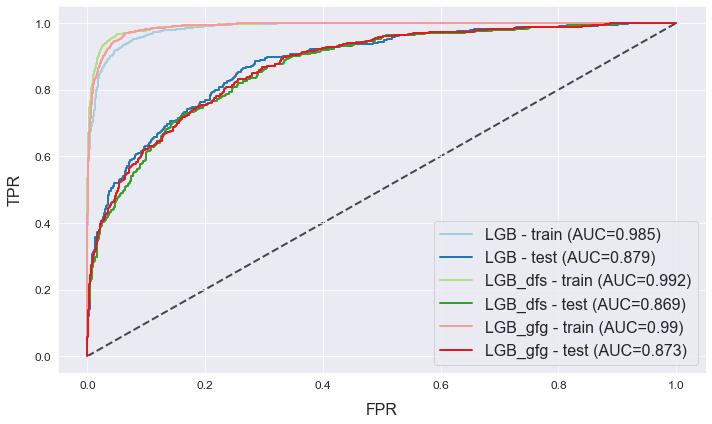

In [17]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

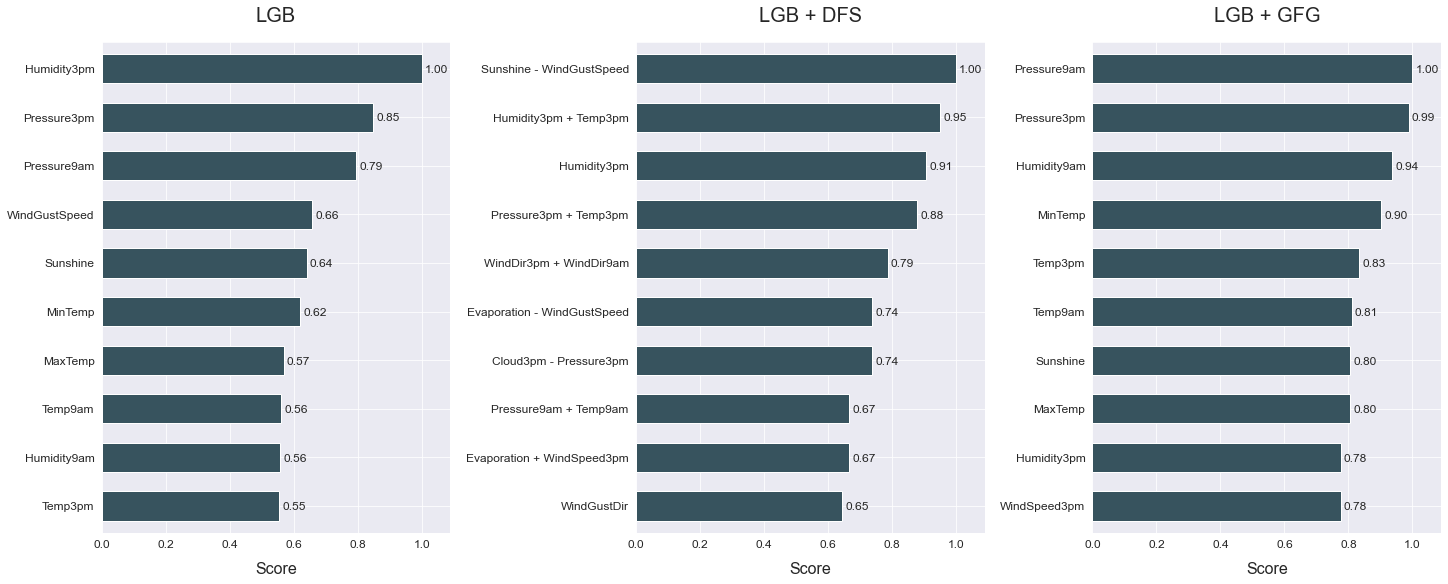

In [18]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + DFS")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + GFG")

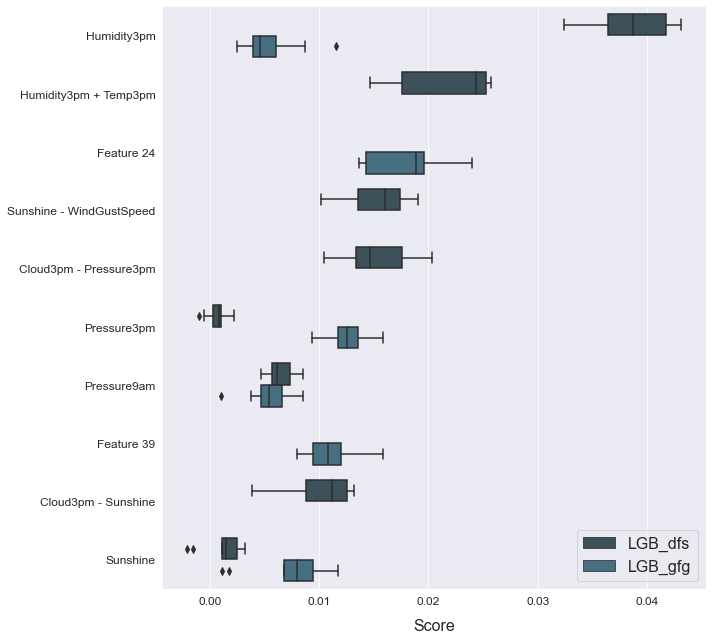

In [19]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_DFS", "LGB_GFG"], show=10)

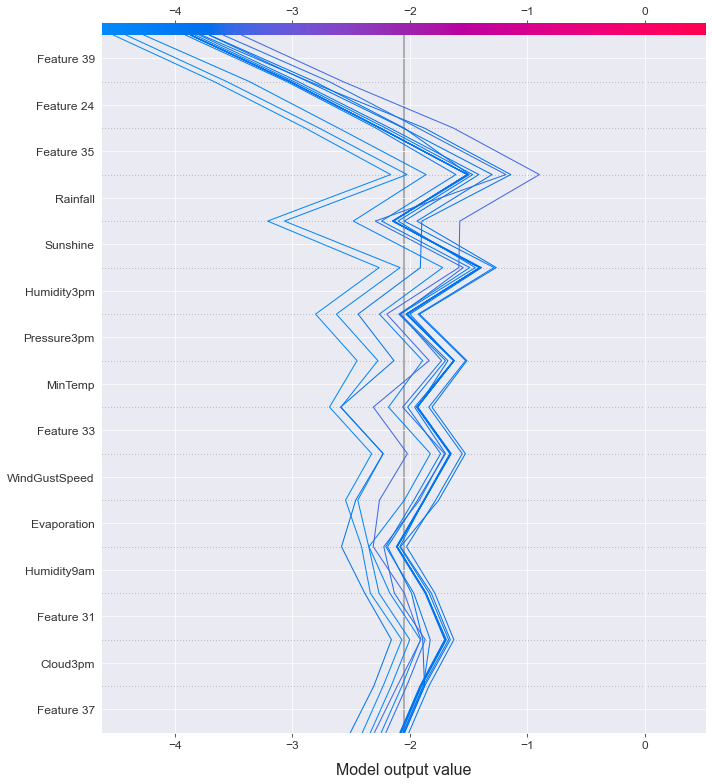

In [20]:
atom.LGB_gfg.decision_plot(index=(-20, -1), show=15)